In [2]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
#from varname import nameof

In [3]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Create dataset for regression analysis

In [4]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [5]:
df = df[df.index.duplicated()==False]  

In [6]:
df["time"] = range(len(df))

In [7]:
solar = pd.read_csv(os.path.join(data_path, "solar.csv"), index_col=0)
solar.index = pd.DatetimeIndex(solar.index)
solar = solar.resample("D").mean()
solar.loc[(solar.index >= df.index[0]) & (solar.index <= df.index[-1])]
solar[solar.index.duplicated()==False]

solar = solar * 2.77778e-7
solar = solar.rename(columns={"solar [J/m^2]" : "solar [kWh/m^2]"})

In [8]:
temperature = pd.read_csv(os.path.join(data_path, "aggregated_temperature.csv"), index_col=0)
temperature.index = pd.DatetimeIndex(temperature.index)
temperature = temperature.resample("D").mean()
temperature = temperature.loc[df.index[0]:df.index[-1]]
temperature[temperature.index.duplicated()==False]

ref_temperature = pd.read_csv(os.path.join(data_path, "aggregated_reference_temperature.csv"), index_col=0)
ref_temperature.index = pd.DatetimeIndex(ref_temperature.index)
ref_temperature = ref_temperature.resample("D").mean()
ref_temperature = ref_temperature.loc[df.index[0]:df.index[-1]]

In [9]:
producing_sector = pd.read_csv(os.path.join(data_path, "manufacturing.csv"), index_col=0, sep=";", dtype={"Kalender- und saisonbereinigt nach X13 JDemetra+":np.float64}, decimal=",")
producing_sector = producing_sector.iloc[:,0] #0: original, 1: adjusted values

producing_sector.index = pd.DatetimeIndex(producing_sector.index)
producing_sector.resample("D").sum()
producing_sector = producing_sector.reindex(df.index, method = "nearest")
producing_sector = producing_sector.loc[df.index[0]:df.index[-1]]
producing_sector.index = df.index 

df["producing_sector"] = producing_sector

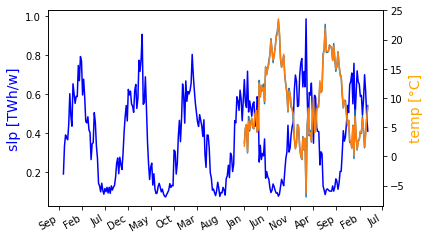

In [10]:
fig,ax = plt.subplots()

ax.plot(df["scaled_space_private"].resample("w").mean(), color="blue")
ax.set_ylabel("slp [TWh/w]",  color="blue", fontsize=14)

ax2=ax.twinx()
ax2.plot(pd.concat([temperature, ref_temperature], axis=1).resample("w").mean())
ax2.set_ylabel("temp [°C]", color="orange", fontsize=14)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

plt.show()

temperature.index = df.index
ref_temperature.index = df.index

df["temperature"] = temperature
df["ref_temperature"] = ref_temperature

# Disaggregation based on fundamental assumption / energy balances

C:\Users\C3250~1.STI\AppData\Local\Temp/ipykernel_11596/1742512260.py:14: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.fill_between(dft.index, upper-sector, upper, color="tab:orange", hatch=h, edgecolor="k", alpha=0.5, label=label)


ConversionError: Failed to convert value(s) to axis units: '2022-01-01'

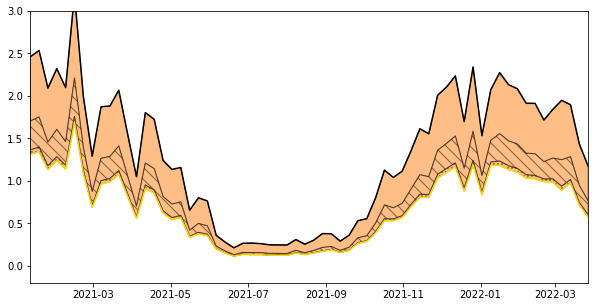

In [12]:
#weekly
plt.figure(figsize=(10,5))
dft = df.resample("1w").mean().dropna()
plt.xlim(dft.index[[0, -1]])

#scaling factors from AGEBL
private = dft["scaled_space_private"] 
tertiary = dft["scaled_space_tertiary"]
decentral_chp = dft["scaled_decentral_chp"]

upper=dft['the_combined_slp']
plt.plot(dft.index, dft['the_combined_slp'], label='THE SLP', color="k")
for sector,h,label in [(private, " ", "private"), (tertiary,  "\\\\", "tertiary"), (decentral_chp, "...", "decentral_chp")]:
    plt.fill_between(dft.index, upper-sector, upper, color="tab:orange", hatch=h, edgecolor="k", alpha=0.5, label=label)
    upper = upper - sector 

plt.plot(upper.index, upper, color="gold", label="residual_SLP")



plt.ylim(-0.2, 3)
plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.21, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))

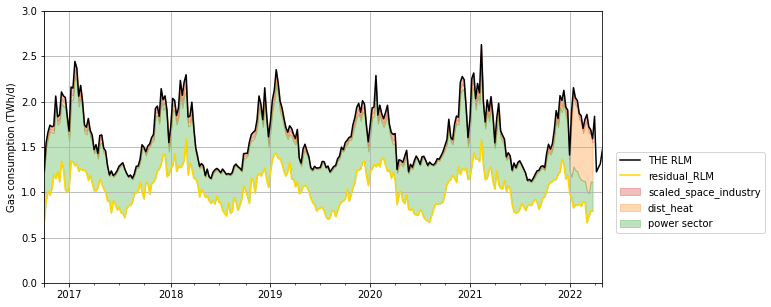

In [13]:
plt.figure(figsize=(10,5))

dft= df.resample("1w").mean()
the_rlm = dft['the_combined_rlm']
the_rlm.plot(label='THE RLM', color="k")

power_res = the_rlm - dft['gas_to_electricity']
industry = dft["scaled_space_industry"]

upper=the_rlm
for sector, c, label in [(industry,"tab:red","scaled_space_industry"), (dft["scaled_district_heat"], "tab:orange", "dist_heat"), (dft['gas_to_electricity'],  "tab:green", "power sector")]:
    plt.fill_between(dft.index, upper-sector, upper , color="{}".format(c), alpha=0.3, label=label)
    upper = upper-sector 
upper.plot(color="gold", label="residual_RLM")

plt.xlim(power_res.dropna().index[[0, -1]])
plt.ylim(0, 3)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

plt.show()

# Estimations: X^= a + b*X

In [14]:
df_x = df
#df_x["power"]=df["electricity_from_gas"]**2
#df_x["power"]=df["electricity_from_gas"]**2
df_x["solar"] = solar
#df_x["temperature"] = temperature
df_x = df_x.rename(columns = {
    "aggregated(incl_small_chp)" : "slp_w2h",
    "dist_heat": "slp_w2h_dh",
    "the_combined_slp" : "slp_the",
    "the_combined_rlm" : "rlm_the",
    "bdew [TWh]" : "bdew",
    "gas_price [€/MWh]" : "prices"
})

In [15]:
df_x["the_sum"] = df_x["rlm_the"] + df_x["slp_the"]

In [16]:
df_x_no_holiday = df_x[(df_x.holiday==0) & (df_x.christmas_period==0) & (df_x.bridgeday==0)]

## Fit model to 2021 and predict for 2022

In [17]:
df_x_no_holiday_2022 = df_x_no_holiday.loc[df_x_no_holiday.index.year == 2022]

In [18]:
df_x_no_holiday_2021 = df_x_no_holiday.loc[df_x_no_holiday.index.year == 2021]

In [ ]:
#df_x_no_holiday = df_x_no_holiday.drop(columns="index")

## THE_RLM

In [19]:
high_gas_date = "2021-09-01"
covid_beginning = "2020-02-01"
invasion_date = "2022-02-24"
limiting_date = "2022-03-31"

df_x_no_holiday = df_x_no_holiday.loc[:limiting_date]

### Fitting period variation

In [20]:
#2020/09-2021/08 (before high gas prices)
model_the_20_09 = smf.ols('rlm_the ~ 1 + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-09-01')])
results_the_20_09 = model_the_20_09.fit() 

model_the_16_10 = smf.ols('rlm_the ~ 1 + slp_the + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <=  high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_16_10 = model_the_16_10.fit() 

result_list = [
    (results_the_20_09,"fitting period: 2020/09 - 2021/08", '2020-09-01', high_gas_date),
    (results_the_16_10,"fitting period: 2016/10 - 2021/08", '2016-10-01', high_gas_date)
]


In [ ]:
#results_the_20_09.summary()
#results_the_16_10.summary()

In [29]:
high_gas_date

'2021-09-01'

In [ ]:
model_the_all = smf.ols('rlm_the ~ 1 + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-10-01')])
results_the_all = model_the_all.fit() 

model_the_no_econ = smf.ols('rlm_the ~ 1 + slp_the + electricity_from_gas + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <=  high_gas_date)&(df_x_no_holiday.index >= '2020-10-01')])
results_the_no_econ = model_the_no_econ.fit() 

model_the_only_slp = smf.ols('rlm_the ~ 1 + slp_w2h + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-10-01')])
results_the_only_slp = model_the_only_slp.fit() 

result_list_2016 = [
    (results_the_only_slp, "only_slp"),
    (results_the_no_econ, "no_econ"),
    (results_the_all,"all")
]

### Controlvariable variation

In [45]:
#2020/09-2021/08 (before high gas prices)
result_list_2016 = []
for model_name in ["only_slp", "no_econ", "all"]:
    
    model = smf.ols(
        'rlm_the ~ 1 + slp_w2h + C(weekday)' 
        + ('+ electricity_from_gas' if model_name != 'only_slp' else '')
        + ('+ producing_sector' if model_name == 'all' else '')
        , data=df_x_no_holiday.loc[
        (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-10-01')]
    )
    results = model.fit() 

    result_list_2016.append((results, model_name))

In [69]:
#results_the_all.summary()
results_the_no_econ.summary()
#results_the_only_slp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rlm_the   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1594.
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          2.44e-238
Time:                        16:34:59   Log-Likelihood:                 410.06
No. Observations:                 305   AIC:                            -802.1
Df Residuals:                     296   BIC:                            -768.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.9584      0.014     66.520      0.000       0.930       0.987
C(weekday)[T.Monday]        0.0514      0.014      3.764      0.000       0.025       0.078
C(weekday)[T.Saturday]     -0.1628      0.014    -11.473      0.000      -0.191      -0.135
C(weekday)[T.Sunday]       -0.1356      0.015     -9.189      0.000      -0.165      -0.107
C(weekday)[T.Thursday]      0.0593      0.014      4.207      0.000       0.032       0.087
C(weekday)[T.Tuesday]       0.0512      0.014      3.747      0.000       0.024       0.078
C(weekday)[T.Wednesday]     0.0529      0.014      3.873      0.000       0.026       0.080
slp_the                     0.3749      0.007     56.537      0.000       0.362       0.388
electricity_from_gas        1.0899      0.051     21.235      0.000       0.989       1.191
==============================================================================
Omnibus:                        2.254   Durbin-Watson:                   0.581
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                2.022
Skew:                           0.119   Prob(JB):                        0.364
Kurtosis:                       3.319   Cond. No.                         25.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
results_the_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rlm_the   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     5741.
Date:                Mon, 13 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:31:26   Log-Likelihood:                 2174.8
No. Observations:                1659   AIC:                            -4330.
Df Residuals:                    1649   BIC:                            -4275.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.7289      0.022     33.517      0.000       0.686       0.772
C(weekday)[T.Monday]        0.0529      0.006      8.790      0.000       0.041       0.065
C(weekday)[T.Saturday]     -0.1580      0.006    -25.633      0.000      -0.170      -0.146
C(weekday)[T.Sunday]       -0.1357      0.006    -21.394      0.000      -0.148      -0.123
C(weekday)[T.Thursday]      0.0500      0.006      8.173      0.000       0.038       0.062
C(weekday)[T.Tuesday]       0.0508      0.006      8.442      0.000       0.039       0.063
C(weekday)[T.Wednesday]     0.0550      0.006      9.198      0.000       0.043       0.067
slp_w2h                     0.7131      0.005    149.583      0.000       0.704       0.722
electricity_from_gas        0.9764      0.021     46.258      0.000       0.935       1.018
producing_sector            0.0024      0.000     12.192      0.000       0.002       0.003
==============================================================================
Omnibus:                       12.895   Durbin-Watson:                   0.548
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               18.864
Skew:                          -0.002   Prob(JB):                     8.01e-05
Kurtosis:                       3.522   Cond. No.                     1.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
def prediction(df, name, start_pred, end_pred, rlm=True):
    delta = pd.DataFrame()
    key_list = ["reported"]

    if rlm == True:
        rlm_slp = "rlm_the"
    else: 
        rlm_slp = "slp_the"
        
    df_pred = df.predict(df_x_no_holiday[df_x_no_holiday.index>=start_pred])
    
    df_pred.name = f"{name}_forecast"

    combined = pd.concat([
        df_pred, df_x_no_holiday.loc[df_x_no_holiday.index>=start_pred][rlm_slp]
    ], axis=1, keys=[name, "reported"])
    print(combined.loc[(combined.index <=end_pred) & (combined.index >=start_pred)].mean())
    ts = (combined.iloc[:,1]-combined.iloc[:,0])
    ts.name = name 
    delta = pd.concat([delta, ts], axis=1)
    
    return combined, delta, key_list

In [47]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

energy_amounts = {
    "phase0" : df_x_no_holiday.loc[df_x_no_holiday.index<=high_gas_date]["rlm_the"],
    "phase1" : df_x_no_holiday.loc[
        (df_x_no_holiday.index>high_gas_date) &
        (df_x_no_holiday.index<=invasion_date)
                                  ]["rlm_the"],
    "phase2" : df_x_no_holiday.loc[df_x_no_holiday.index>invasion_date]["rlm_the"]
}

In [48]:
start_pred = high_gas_date
end_pred = limiting_date

for df, name in result_list_2016:
    
    combined, delta, key_list = prediction(df, name, start_pred, end_pred)
    
    result_dict[name]["phase0"] = (
        delta[name][delta[name].index <= high_gas_date].sum() / 
                                   energy_amounts["phase0"].sum()
                                  )
    result_dict[name]["phase1"] = delta[name][
        (delta[name].index > high_gas_date) & 
        (delta[name].index <=invasion_date)
    ].sum() / energy_amounts["phase1"].sum()
    result_dict[name]["phase2"] = delta[name][delta[name].index > invasion_date].sum() / energy_amounts["phase2"].sum()

only_slp    2.056453
reported    1.719066
dtype: float64
no_econ     1.909217
reported    1.719066
dtype: float64
all         1.919599
reported    1.719066
dtype: float64


In [49]:
(pd.DataFrame.from_dict(result_dict, orient="index").transpose()*100)

,only_slp,no_econ,all
phase0,-0.001636,-0.001497,-0.001590
phase1,-15.098489,-8.044556,-8.374251
phase2,-35.104504,-21.207483,-22.917477


Text(0, 0.5, 'estimated reduction [%]')

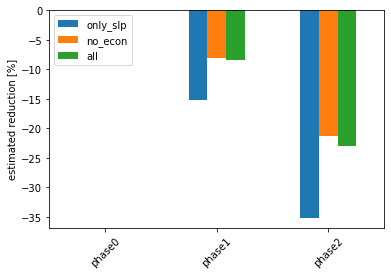

In [50]:
ax = (pd.DataFrame.from_dict(result_dict, orient="index").transpose()*100).plot(kind = "bar", rot=45)
ax.set_ylabel("estimated reduction [%]")

In [35]:
result_list = [(results_the_no_econ,"fitting period: 2016/10 - 2021/08", '2016-10-01', high_gas_date)]
#(, "no_econ"),

fitting period: 2016/10 - 2021/08    1.61142
reported                             1.61142
dtype: float64


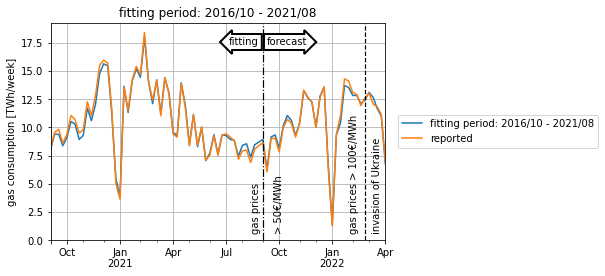

In [36]:
for df, name, start_pred, end_pred in result_list:
    
    combined, delta, key_list = prediction(df, name, start_pred, end_pred)
    
    ax =combined.loc["2020-09-01":].resample("1w").sum().plot(ylim=0, xlim=("2020-09-01",limiting_date), title = name)
    ax.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
    ax.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )
    
    ax.text((pd.to_datetime(high_gas_date)-pd.Timedelta(18, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices" +"\n"+"\n" + "> 50€/MWh", size=10, rotation=90)
    ax.text((pd.to_datetime(invasion_date)-pd.Timedelta(30, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices > 100€/MWh" + "\n" +"\n" + "invasion of Ukraine", size=10, rotation=90)
    
    fit = ax.text(
        (pd.to_datetime(high_gas_date)-pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 18, "fitting", ha="right", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
    forecast = ax.text(
        (pd.to_datetime(high_gas_date)+pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 18, "forecast", ha="left", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))
    
    plt.grid()
    ax.set_ylabel("gas consumption [TWh/week]")
    ax.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
    
    plt.show()
    
    key_list.append(name)
    

In [51]:
delta.index = combined.index
delta_rlm = delta.dropna()

Q1_delta_rlm = delta_rlm["2022-02-24":].sum(0)

percent = Q1_delta_rlm / combined.loc["2022-02-24":,"reported"].sum(0)*100

weekly_rlm = Q1_delta_rlm / len(delta_rlm["2022-02-24":].index) * 7

print(
    "since war [TWh]:"+ "\n"+ str(Q1_delta_rlm) + "\n" + "\n" +
    "since war [%]:" + "\n"+ str(percent) + "\n" + "\n" +
    "weekly [TWh]:" + "\n"+ str(weekly_rlm)
     )

since war [TWh]:
all   -14.137615
dtype: float64

since war [%]:
all   -22.801188
dtype: float64

weekly [TWh]:
all   -3.298777
dtype: float64


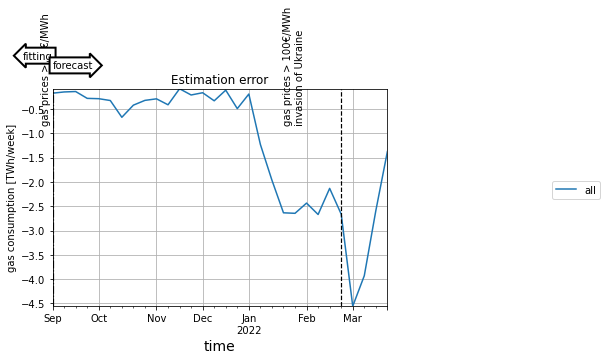

In [52]:
resampled = delta_rlm.resample("1w").sum()

resampled.loc[resampled.index>="2021-08-01"].plot(ylim=delta_rlm["2022-02-24":].min().min(),  title="Estimation error").set_ylabel("gas consumption [TWh/week]")
plt.grid() 
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 0.5))

plt.ylim(resampled.min()[0], resampled.max()[0])


plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
plt.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )

plt.text((pd.to_datetime(high_gas_date)-pd.Timedelta(9, "days")).strftime('%Y-%m-%d'), -0.8, "gas prices > 50€/MWh", size=10, rotation=90)
plt.text((pd.to_datetime(invasion_date)-pd.Timedelta(35, "days")).strftime('%Y-%m-%d'), -0.8, "gas prices > 100€/MWh" + "\n" + "invasion of Ukraine", size=10, rotation=90)

plt.ylabel("gas consumption [TWh/week]")
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
plt.xlabel("time",fontsize=14)
plt.axhline(y=0, color='k', lw=1)

fit = plt.text(
    (pd.to_datetime(high_gas_date)-pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 0.7, "fitting", ha="right", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
forecast = plt.text(
    (pd.to_datetime(high_gas_date)+pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 0.5, "forecast", ha="left", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))

ConversionError: Failed to convert value(s) to axis units: '2022-02-24'

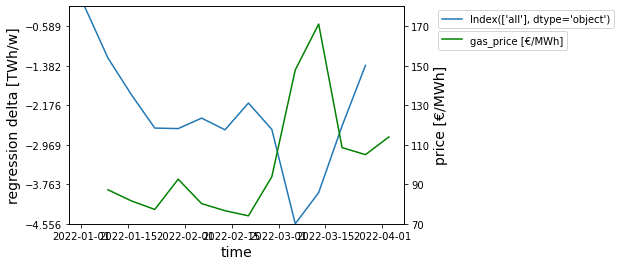

In [53]:
fig,ax = plt.subplots()

column = delta_rlm.columns#[1] 
data = delta_rlm.loc[delta_rlm.index.year==2022, column].resample("w").sum()

ax.plot(data, label=column)

ax.set_ylim(data.min()[0], data.max()[0])
ax.set_xlabel("time",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)

step_size = 20 / 110*((data.max() - data.min())[0]) 
ax.set_yticks(np.arange(data.min()[0], data.max()[0], step_size))

ax.legend(loc=(1.1,0.9))

ax2=ax.twinx()
ax2.plot(df_x_no_holiday["prices"][df_x_no_holiday.index.year==2022].resample("w").mean(), color="green", label="gas_price [€/MWh]")

ax2.set_ylabel("price [€/MWh]", fontsize=14)
ax2.set_ylim(70, 180)
ax2.set_yticks(np.arange(70, 180, 20))

ax2.legend(loc=(1.1,0.8))

plt.axvline(x=invasion_date, color='k', lw=0.7)
#plt.axhline(y=0, color='k', lw=1.2)

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid()
plt.show()

## SLP

In [68]:
#SLP
model_the_slp = smf.ols('slp_the ~ 1 + slp_w2h + C(weekday)', 
                            data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_slp = model_the_slp.fit() 
#results_the_slp.summary()

## Vizualize and analyze predictions

<AxesSubplot:>

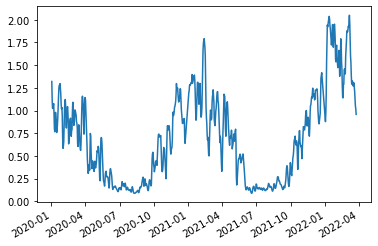

In [67]:
df_x_no_holiday[df_x_no_holiday.index.year>=2020]['slp_w2h'].plot()

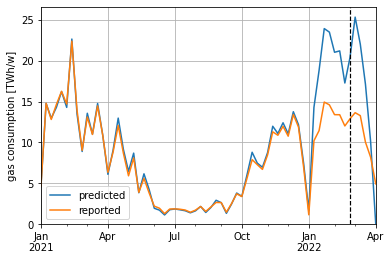

In [59]:
the_slp_prediction = results_the_slp.predict(df_x_no_holiday[df_x_no_holiday.index.year>=2021])
the_slp_prediction.name = "the_slp_forecast"

the_slp_combined = pd.concat([
    the_slp_prediction, df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["slp_the"]
], axis=1, keys=["predicted", "reported"])

the_slp_combined.resample("1w").sum().plot(ylim=0).set_ylabel("gas consumption [TWh/w]")
plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
plt.grid() 


plt.show()


In [56]:
delta_the_slp = the_slp_combined.iloc[:,1]-the_slp_combined.iloc[:,0]

Text(0, 0.5, 'regression delta [TWh/w]')

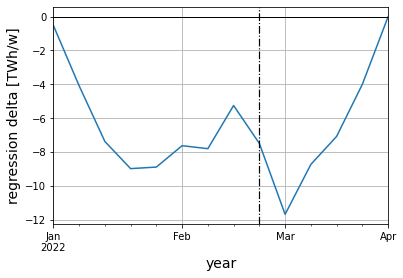

In [57]:
ax = delta_the_slp.loc[delta_the_slp.index.year==2022].resample("w").sum().plot()
ax.axvline(x=invasion_date, color='k', linestyle='-.', lw=1.2 )
ax.axhline(y=0, color='k', lw=1)
plt.grid()
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)


# Further regression variations

In [ ]:
high_gas_date = "2021-09-01"
covid_beginning = "2020-02-01"
invasion_date = "2022-02-24"
limiting_date = "2022-03-31"

In [ ]:
dummy_1 = pd.concat([
    pd.Series(0,index=df_x_no_holiday.index[df_x_no_holiday.index<high_gas_date]),
    pd.Series(1,index=df_x_no_holiday.index[
        (df_x_no_holiday.index>=high_gas_date)&
        (df_x_no_holiday.index<invasion_date)]),
    pd.Series(0,index=df_x_no_holiday.index[df_x_no_holiday.index>invasion_date])
              
              ])

dummy_2 = pd.concat([
    pd.Series(0,index=df_x_no_holiday.index[df_x_no_holiday.index<invasion_date]),
    pd.Series(1,index=df_x_no_holiday.index[df_x_no_holiday.index>=invasion_date]),
])

In [ ]:
df_x_no_holiday["D1"] = dummy_1
df_x_no_holiday["D2"] = dummy_2

In [ ]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

#2020/09-2021/08 (before high gas prices)

model_rdd_only_slp = smf.ols('rlm_the ~ 1 +  D1 + D2 + slp_w2h + C(weekday)', data=df_x_no_holiday)
results_rdd_only_slp = model_rdd_only_slp.fit()

model_rdd_no_econ = smf.ols('rlm_the ~ 1 + D1 + D2+ slp_the + electricity_from_gas + C(weekday)', data=df_x_no_holiday)
results_rdd_no_econ = model_rdd_no_econ.fit() 

 
model_rdd_all = smf.ols('rlm_the ~ 1 + D1 + D2 + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday)
results_rdd_all = model_rdd_all.fit() 

In [ ]:
ax = pd.DataFrame(
    data=np.array([
    (results_rdd_all.params.D1, results_rdd_no_econ.params.D1,  results_rdd_only_slp.params.D1), 
    ( results_rdd_only_slp.params.D2, results_rdd_no_econ.params.D2, results_rdd_all.params.D2),
    ]), index=["phase1", "phase2"], columns=["only_slp", "no_econ", "all"]
).plot(kind="bar")
             
ax.set_ylabel("estimated reduction [%]")

In [ ]:
#Prices
model_the_prices = smf.ols('rlm_the ~ 1 + prices + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', 
                            data=df_x_no_holiday)
results_the_prices = model_the_prices.fit() 
#results_the_prices.summary()

In [ ]:
dummy_coefficients = pd.DataFrame(columns=["dummy_coefficients", "P_value"])

for date in pd.date_range("2020-01-01", "2022-03-01", freq="M"):
    
    dummy = pd.concat([
        pd.Series(0,index=df_x_no_holiday.index[df_x_no_holiday.index<date.strftime('%Y-%m-%d')]),
        pd.Series(1,index=df_x_no_holiday.index[df_x_no_holiday.index>=date.strftime('%Y-%m-%d')]),
    ])
    
    df_x_no_holiday["dummy"] = dummy
    
    model = 'rlm_the ~ 1 + dummy + slp_w2h + time + electricity_from_gas + producing_sector + C(weekday)'
    results = smf.ols(model, df_x_no_holiday).fit()
    
    dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "dummy_coefficients"] = results.params.dummy
    dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "P_value"] = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0].loc["dummy"]["P>|t|"]

In [ ]:
dummy_coefficients.plot(ylim=(-0.3,0.1))
plt.grid()